# Représentations par matrices de co-occurrence

In [ ]:
!pip install tweet-preprocessor

In [ ]:
import json
import numpy as np
import pandas as pd
import gensim
import preprocessor as p
from preprocessor import clean
import collections

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re 

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving covid19_tweets.csv to covid19_tweets.csv


In [ ]:
# importing data

covid_raw = pd.read_csv('covid19_tweets.csv')
covid_raw.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


## Pré-traitement

In [ ]:
#Create  functions 

def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    data = re.sub(r'[^\w\s]','',data)
    return data    

def remove_stop_words(data):
    """
    Removing stop words from text. Still possible to add custom stop words  
    """
    return [word for word in data if not word in stopwords.words()]

def preprocess_tweet(row):
    text = clean(row)
    return text

def preprocess(data):
    data = preprocess_tweet(data)
    data = remove_punctuation(data)
    data = convert_lower_case(data)
    return data

In [ ]:
covid = covid_raw['text'].apply(preprocess)
covid_list = [tweet.split() for tweet in covid]
len(covid_list)

179108

## Co-occurrence embeddings

In [ ]:
class CooccEmbedding:
    def __init__(self, corpus):
        """
        Takes in the corpus in the form of a list of lists (list of tweets, 
        each tweet being a list of tokens)
        """
        self.corpus = corpus
       
    
    def vocabulary(self):
        """
        Returns the vocabulary associated with the corpus (a list of unique tokens from the corpus)
        """
        self.vocab = []
        [self.vocab.append(word) for sent in self.corpus for word in sent if word not in self.vocab]
        return self.vocab
    
    def coocc_matrix(self):
        """
        Returns the co-occurrence matrix associated with the corpus.
        The co-occurrence matrix is first calculated as a list using list comprehension to speed up 
        the iteration process over the vocabulary and the corpus.
        """
        self.len_vocab = len(self.vocab)
        coocc_list = [sum([1 if (self.vocab[i] in sent and self.vocab[j] in sent and i != j) else 0 for sent in self.corpus])  
                      for i in range(self.len_vocab) for j in range(self.len_vocab)]
        coocc_list = np.array(coocc_list)
        # transform the coocc_list into a matrix
        self.coocc_mat = coocc_list.reshape([self.len_vocab, self.len_vocab])
        return self.coocc_mat

        
    def svd_reduction(self, n_components = 2, n_iter = 10):
        """
        Performs a singular value decomposition on the co-occurrence matrix M and returns the truncated
        matrix U, where M = UDV^T.
        """
        svd = TruncatedSVD(n_components = n_components, n_iter = n_iter)
        self.reduced_matrix = svd.fit_transform(self.coocc_mat)
        return self.reduced_matrix
    
    def vocab_ind_to_plot(self, vocab_to_plot):
        """
        Takes in the a list of vocabulary to plot and returns a dictionary in the form of
        {word:index} which is a subeset of the vocabulary.
        """
        vocab_dict = dict(zip(self.vocab, range(self.len_vocab)))
        self.dic_vocab_to_plot = {key:value for key, value in vocab_dict.items() if key in vocab_to_plot}
        return self.dic_vocab_to_plot
        
    

## Exemple sur une instance

In [ ]:
inst = CooccEmbedding(covid_list[:200])
len(inst.vocabulary())

1210

In [ ]:
inst.coocc_matrix()

array([[0, 2, 1, ..., 0, 0, 0],
       [2, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 1, 0]])

## Dimensionality reduction

In [ ]:
svd_matrix = inst.svd_reduction()

In [ ]:
corpus = [word for items in covid_list[:200] for word in items]
word_freq = {w:corpus.count(w) for w in corpus}
word_freq_reverse = {k: word_freq[k] for k 
                          in sorted(word_freq, key=word_freq.get, reverse=True)}

In [ ]:
word_freq_reverse

{'the': 103,
 'to': 100,
 'of': 57,
 'and': 56,
 'in': 55,
 'a': 47,
 'is': 33,
 'for': 28,
 'you': 26,
 'cases': 25,
 'on': 22,
 'that': 21,
 'this': 18,
 'covid19': 18,
 'from': 18,
 'testing': 18,
 'it': 17,
 'have': 16,
 'i': 15,
 'are': 15,
 'new': 15,
 'by': 15,
 'at': 14,
 'we': 13,
 'an': 13,
 'with': 13,
 'total': 13,
 'their': 12,
 'as': 12,
 'your': 12,
 'be': 12,
 'coronavirus': 11,
 'has': 10,
 'deaths': 10,
 'people': 10,
 'not': 10,
 'if': 9,
 'its': 9,
 'will': 9,
 'our': 9,
 'but': 9,
 'what': 9,
 'about': 9,
 'were': 8,
 'one': 8,
 'how': 8,
 'out': 8,
 'government': 8,
 'review': 8,
 'positive': 8,
 'against': 8,
 'due': 8,
 'there': 8,
 'so': 7,
 'all': 7,
 'july': 7,
 'can': 7,
 'fight': 7,
 'us': 7,
 'like': 7,
 'fiasco': 7,
 'st': 7,
 'mirrenhave': 7,
 'pledged': 7,
 'undertake': 7,
 'urgent': 7,
 'proced': 7,
 'today': 6,
 'more': 6,
 'me': 6,
 'want': 6,
 'now': 6,
 'please': 6,
 'tested': 6,
 'see': 6,
 'covid': 6,
 'im': 6,
 'he': 6,
 'spread': 6,
 'my': 6,
 

In [ ]:
vocab_to_plot = ['covid', 'cases', 'testing', 'new', 'coronavirus', 'total', 'government', 'pandemic', 'mask', 'wear']

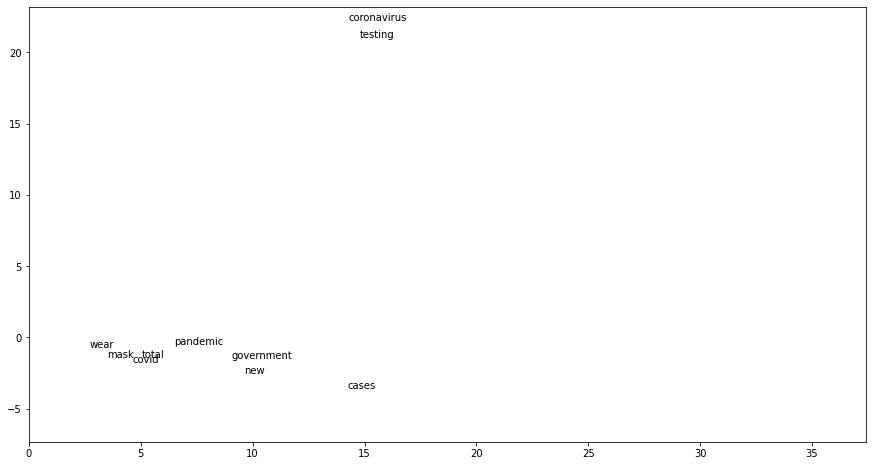

In [ ]:
plt.figure(figsize = (15, 8))
plt.xlim(min(svd_matrix[:, 0]), max(svd_matrix[:, 0] - 30))
plt.ylim(min(svd_matrix[:, 1] + 5), max(svd_matrix[:, 1]+1))

dict_to_plot = inst.vocab_ind_to_plot(vocab_to_plot)

for word, ind in dict_to_plot.items():
    plt.text(svd_matrix[ind, 0], svd_matrix[ind, 1], word)   

# Explorer les représentations distribuées avec Word2Vec

In [ ]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt

In [ ]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: 2.5 million of 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    from gensim.models import KeyedVectors
    # let's load 2.5 million of the 3 million word embeddings so we don't run out of memory on Colab
    wv_from_bin = KeyedVectors.load_word2vec_format(api.load("word2vec-google-news-300", return_path=True), limit=2500000, binary=True)
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [ ]:
wv_from_bin = load_word2vec()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 2500000


In [ ]:
wv_from_bin['king']

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [ ]:
# Top-10 most similar words
wv_from_bin.most_similar("sheep")

[('lambs', 0.7151363492012024),
 ('cows', 0.7045579552650452),
 ('goats', 0.6998268365859985),
 ('cattle', 0.6972129344940186),
 ('livestock', 0.6748517155647278),
 ('ewes', 0.6546227931976318),
 ('lamb', 0.6539288759231567),
 ('goat', 0.6466525197029114),
 ('herd', 0.6429063081741333),
 ('Sheep', 0.6376320123672485)]

In [ ]:
# analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man'])[0])

('queen', 0.7118192911148071)


In [ ]:
# Analogy -- France : Paris :: Berlin

pprint.pprint(wv_from_bin.most_similar(positive=['Germany', 'Paris'], negative=['France'])[0])

('Berlin', 0.7644002437591553)


In [ ]:
# NLP bias
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'doctor'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'doctor'], negative=['woman']))

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.647728681564331),
 ('doctors', 0.6471461057662964),
 ('physician', 0.64389967918396),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218312978744507),
 ('obstetrician', 0.6072014570236206),
 ('ob_gyn', 0.5986712574958801),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566683769226)]

[('physician', 0.6463665962219238),
 ('doctors', 0.5858404040336609),
 ('surgeon', 0.5723941326141357),
 ('dentist', 0.552364706993103),
 ('cardiologist', 0.5413815975189209),
 ('neurologist', 0.5271126627922058),
 ('neurosurgeon', 0.5249835848808289),
 ('urologist', 0.5247740149497986),
 ('Doctor', 0.5240625143051147),
 ('internist', 0.5183224081993103)]
